In [6]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pulp

### Load data

In [7]:
selection_df = pd.read_pickle('../../data/processed/live_selections.pkl')

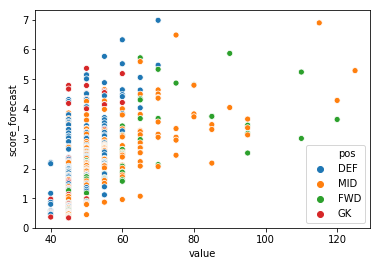

In [8]:
sns.scatterplot(data=selection_df,x='value',y='score_forecast',hue='pos')

### Select best 15 players

choose highest expected points per game, subject to constraints on total cost, and positions 

note - doesn't capture fact that subs are less valuable (particularly 2nd keeper)

removing new-joiners, and manually dropping some guys that moved club

In [10]:
BLACKLIST = []

In [11]:
selection_df = selection_df.loc[~selection_df.clean_name.isin(BLACKLIST),:]

In [12]:
def select_best_15(data,prediction_col):
    player_ids = [str(i) for i in range(data.shape[0])]

    # Setup
    point = dict(zip(player_ids,data[prediction_col]))
    cost = dict(zip(player_ids,data.value))
    gk = dict(zip(player_ids,(data.pos == 'GK').astype(int)))
    defe = dict(zip(player_ids,(data.pos == 'DEF').astype(int)))
    mid = dict(zip(player_ids,(data.pos == 'MID').astype(int)))
    stri = dict(zip(player_ids,(data.pos == 'FWD').astype(int)))
    
    prob = pulp.LpProblem("Fantasy Football",pulp.LpMaximize)
    player_vars = pulp.LpVariable.dicts("Players",player_ids,0,1,pulp.LpBinary)

    # objective function
    prob += pulp.lpSum([point[i]*player_vars[i] for i in player_ids]), "Total Cost"

    # constraint
    prob += pulp.lpSum([player_vars[i] for i in player_ids]) == 15, "Total 15 Players"
    prob += pulp.lpSum([cost[i] * player_vars[i] for i in player_ids]) <= 1000, "Total Cost"
    prob += pulp.lpSum([gk[i] * player_vars[i] for i in player_ids]) == 2, "2 GK"
    prob += pulp.lpSum([defe[i] * player_vars[i] for i in player_ids]) == 5, "5 DEF"
    prob += pulp.lpSum([mid[i] * player_vars[i] for i in player_ids]) == 5, "5 MID"
    prob += pulp.lpSum([stri[i] * player_vars[i] for i in player_ids]) == 3, "Less than 3 STR"

    # solve
    status = prob.solve()
    
    return status, prob, [int(f.name.replace('Players_','')) for f in prob.variables() if f.varValue == 1 ]

In [13]:
_, _, selections_lgb = select_best_15(selection_df,'score_forecast')

In [14]:
def show_team(candidates, selection):
    position_map = {'GK':1,'DEF':2,'MID':3,'FWD':4}
    candidates['position_num'] = candidates.pos.map(position_map)
    return candidates.iloc[selection].sort_values(by='position_num').drop(columns='position_num')

In [15]:
selected_lgb = show_team(selection_df,selections_lgb); selected_lgb

,clean_name,pos,score_forecast,value,selected_by_percent
226,Lukasz_Fabianski,GK,5.366062,50,10.2
202,Kasper_Schmeichel,GK,5.147324,50,5.1
355,Trent_Alexander-Arnold,DEF,6.978821,70,28.7
275,Nathan_Aké,DEF,5.145308,50,16.8
222,Lucas_Digne,DEF,6.323681,60,27.8
2,Aaron_Wan-Bissaka,DEF,5.767731,55,32.4
305,Ricardo Domingos_Barbosa Pereira,DEF,5.518839,60,8.0
324,Sadio_Mané,MID,6.891938,115,24.8
320,Ryan_Fraser,MID,6.483821,75,21.4
196,João Filipe Iria_Santos Moutinho,MID,4.654236,55,6.8


In [16]:
selected_lgb.value.sum()

1000